# GRU model

## 1. Import data

In [2]:
import pandas as pd
import sys
import numpy as np

sys.path.append('/kaggle/input/utility-scripts')
from features import add_features

In [3]:
# Import datasets
train_series = pd.read_csv("/kaggle/input/input-data/filtered_train_series_continuous.csv")
test_series = pd.read_csv("/kaggle/input/input-data/filtered_test_series_continuous.csv")

In [4]:
# Add features
train_series = add_features(train_series)
test_series = add_features(test_series)

In [5]:
print(train_series.shape)
print(test_series.shape)

(787158, 40)
(204125, 40)


In [6]:
# Delete NAs
train_series = train_series.dropna()
test_series = test_series.dropna()
print(train_series.shape)
print(test_series.shape)

(786942, 40)
(204072, 40)


### Reshape the training data into 3D with SMOTE

So that it includes time windows (50 = ~7h)

In [7]:
from imblearn.over_sampling import SMOTE

In [8]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE

def convert_to_3d(df, timestep_length=50):
    # Ensure the DataFrame is sorted by series_id and step
    df = df.sort_values(by=["series_id", "step"])    
    # Extract unique series IDs
    ids = df["series_id"].unique()
        
    # Extract the events
    events = df["event"]
    # Remove the 'series_id' and 'events' column from the features
    features = df.drop(columns=["series_id", "event"])
    
    # SMOTE 
    smote = SMOTE(random_state=42)
    smote_series, smote_event = smote.fit_resample(features, events)
    
    # Get the number of rows in the SMOTE resampled events
    num_rows = len(smote_event)
    # Truncate to the largest multiple of timestep_length
    num_rows_to_keep = num_rows - (num_rows % timestep_length)
    
    # Reshape the events array
    reshaped_event = smote_event[:num_rows_to_keep].values.reshape(-1, timestep_length)
    # Reshape the dataframe into a 3D numpy array: (n_series, timesteps, features)
    reshaped_data = smote_series[:num_rows_to_keep].values.reshape(-1, timestep_length, smote_series.shape[1])
    
    return reshaped_data, reshaped_event

In [9]:
shaped_train_data, shaped_train_tar = convert_to_3d(train_series)
shaped_test_data, shaped_test_tar = convert_to_3d(test_series)

In [10]:
print("Train data:")
print(shaped_train_data.shape)
print(shaped_train_tar.shape, "\n")
print("Test data:")
print(shaped_test_data.shape)
print(shaped_test_tar.shape)

Train data:
(46779, 50, 38)
(46779, 50) 

Test data:
(12121, 50, 38)
(12121, 50)


In [11]:
# Calculate class weights
unique, counts = np.unique(shaped_train_tar, return_counts=True)
weights = counts.sum()/counts
print(weights)

[2.99997691 2.99997691 3.00004618]


### One hot encoding

In [12]:
import keras

In [13]:
shaped_train_target = keras.utils.to_categorical(shaped_train_tar)
shaped_test_target = keras.utils.to_categorical(shaped_test_tar)

In [14]:
print("One hot encoded targets:")
print(shaped_train_target.shape)
print(shaped_test_target.shape)

One hot encoded targets:
(46779, 50, 3)
(12121, 50, 3)


## 2. Build and run model

In [15]:
# Suppress TensorFlow warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from tensorflow import keras
import tensorflow as tf
from sklearn.model_selection import KFold
from keras.models import Sequential
from keras.layers import GRU, Dense, Input, Bidirectional, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from tensorflow.keras import backend as K
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_curve

### Home-made loss function

In [16]:
def weighted_categorical_crossentropy(weights):
    
    weights = K.variable(weights)

    def loss(y_true, y_pred):
        """Calculate weighted categorical crossentropy loss."""
        # Clip predictions to avoid log(0)
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        
        # Calculate unweighted categorical crossentropy
        cce = y_true * K.log(y_pred)
        
        # Multiply with weights for each class
        weighted_cce = cce * weights
        
        # Take mean across timesteps and batch dimensions
        return -K.mean(K.sum(weighted_cce, axis=-1))  # sum across classes, mean across batch and timesteps

    return loss

### Build and train the model

In [17]:
def find_optimal_threshold(test_target_classes, test_pred, num_classes=3):
    thresholds = np.arange(0.1, 0.9, 0.01)  # Range of thresholds to search
    best_thresholds = []
    best_f1_scores = []
    
    # Loop through each class to find the best threshold for maximizing F1 score
    for i in range(num_classes):
        f1_scores = []
        for threshold in thresholds:
            # Binarize predictions using the threshold
            binary_pred = (test_pred[:, i] >= threshold).astype(int)
            binary_true = (test_target_classes == i).astype(int)

            # Compute F1 score
            f1 = f1_score(binary_true, binary_pred, zero_division=1)
            f1_scores.append(f1)

        # Get the best threshold for this class
        best_idx = np.argmax(f1_scores)
        best_thresholds.append(thresholds[best_idx])
        best_f1_scores.append(f1_scores[best_idx])

        print(f"Class {i} - Best Threshold: {best_thresholds[-1]}, Best F1 Score: {best_f1_scores[-1]}")
    
    return best_thresholds, best_f1_scores

In [18]:
def build_gru_model(input_shape):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Bidirectional(GRU(units=64, return_sequences=True)))
    model.add(Bidirectional(GRU(units=32, return_sequences=True)))
    model.add(Dense(units=3, activation='softmax'))
    
    return model


def train_gru_model(train_series, train_target,
                    test_series, test_target,
                   class_weights):
    
    # Ensure data is in the correct numerical format
    train_series = np.array(train_series, dtype=np.float32)
    train_target = np.array(train_target, dtype=np.int32)
    test_series = np.array(test_series, dtype=np.float32)
    test_target = np.array(test_target, dtype=np.int32)

    # Define the input shape for the GRU model
    input_shape = train_series.shape[1:]
    
    # Build and compile the GRU model
    model = build_gru_model(input_shape)
    model.compile(loss=weighted_categorical_crossentropy(class_weights), 
                  optimizer='adam', metrics=['accuracy', 'precision'])

    # Define early stopping
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train the model
    history = model.fit(x=train_series, y=train_target, batch_size=32,
                        validation_data=(test_series, test_target), 
                        epochs=20, callbacks=[early_stop])

    # Evaluate the model on the validation set
    test_pred = model.predict(test_series).reshape(-1, 3)
    test_target_classes = np.argmax(test_target.reshape(-1, 3), axis=1)

    # Find optimal thresholds for each class
    best_thresholds, _ = find_optimal_threshold(test_target_classes, test_pred)

    # Apply the optimal thresholds to get final predictions
    final_pred_classes = []
    for i in range(len(best_thresholds)):
        # Binarize predictions using the optimal thresholds
        binary_pred = (test_pred[:, i] >= best_thresholds[i]).astype(int)
        final_pred_classes.append(binary_pred)

    # Combine final predictions for each class
    final_pred_classes = np.array(final_pred_classes).T  # Shape: (num_samples, num_classes)
    
    # Get the predicted class based on the maximum value across the classes
    final_pred_classes = np.argmax(final_pred_classes, axis=1)

    # Calculate precision, accuracy, recall, and F1-score
    precision = precision_score(test_target_classes, final_pred_classes, average='macro')
    accuracy = accuracy_score(test_target_classes, final_pred_classes)
    recall = recall_score(test_target_classes, final_pred_classes, average='macro')
    f1 = f1_score(test_target_classes, final_pred_classes, average='macro')

    # Save the metrics for this fold
    metrics = {
        'precision': precision,
        'accuracy': accuracy,
        'recall': recall,
        'f1_score': f1
    }
    
    return model, metrics

In [19]:
model, metrics = train_gru_model(shaped_train_data, shaped_train_target, 
                                 shaped_test_data, shaped_test_target,
                                 weights)

Epoch 1/20
1462/1462 ━━━━━━━━━━━━━━━━━━━━ 27s 15ms/step - accuracy: 0.8826 - loss: 0.9306 - precision: 0.9033 - val_accuracy: 0.9338 - val_loss: 0.5239 - val_precision: 0.9342
Epoch 2/20
1462/1462 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.9529 - loss: 0.4019 - precision: 0.9531 - val_accuracy: 0.9423 - val_loss: 0.4519 - val_precision: 0.9425
Epoch 3/20
1462/1462 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.9589 - loss: 0.3583 - precision: 0.9591 - val_accuracy: 0.9464 - val_loss: 0.4293 - val_precision: 0.9465
Epoch 4/20
1462/1462 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.9592 - loss: 0.3559 - precision: 0.9593 - val_accuracy: 0.9356 - val_loss: 0.5036 - val_precision: 0.9357
Epoch 5/20
1462/1462 ━━━━━━━━━━━━━━━━━━━━ 41s 14ms/step - accuracy: 0.9608 - loss: 0.3372 - precision: 0.9609 - val_accuracy: 0.9447 - val_loss: 0.4370 - val_precision: 0.9449
Epoch 6/20
1462/1462 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.9626 - loss: 0.3256 - precision: 0.9627 - val_accu

### K-fold validation

In [20]:
def train_gru_model_with_kfold(series, target, class_weights, k=3):
    
    # Ensure data is in the correct numerical format
    series = np.array(series, dtype=np.float32)
    target = np.array(target, dtype=np.int32)

    # Initialize the KFold cross-validator
    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    histories = []
    fold_metrics = []

    # Perform K-Fold cross-validation
    for fold, (train_idx, test_idx) in enumerate(kf.split(series)):
        print(f"\nTraining fold {fold + 1}/{k}...")

        # Split the data into train and validation sets
        train_series, test_series = series[train_idx], series[test_idx]
        train_target, test_target = target[train_idx], target[test_idx]

        # Train the GRU model
        model, metrics = train_gru_model(train_series, train_target, test_series, test_target, class_weights)

        # Save the history and model for this fold
        histories.append(model.history)

        # Save metrics for this fold
        fold_metrics.append(metrics)

    return histories, fold_metrics

In [21]:
histories, fold_metrics = train_gru_model_with_kfold(shaped_train_data, shaped_train_target, weights)


Training fold 1/3...
Epoch 1/20
975/975 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - accuracy: 0.8712 - loss: 1.0377 - precision: 0.8955 - val_accuracy: 0.9569 - val_loss: 0.3847 - val_precision: 0.9571
Epoch 2/20
975/975 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.9535 - loss: 0.4227 - precision: 0.9538 - val_accuracy: 0.9576 - val_loss: 0.3761 - val_precision: 0.9581
Epoch 3/20
975/975 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.9588 - loss: 0.3710 - precision: 0.9590 - val_accuracy: 0.9532 - val_loss: 0.4020 - val_precision: 0.9534
Epoch 4/20
975/975 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.9569 - loss: 0.3748 - precision: 0.9571 - val_accuracy: 0.9620 - val_loss: 0.3295 - val_precision: 0.9621
Epoch 5/20
975/975 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.9579 - loss: 0.3626 - precision: 0.9581 - val_accuracy: 0.9592 - val_loss: 0.3444 - val_precision: 0.9594
Epoch 6/20
975/975 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.9594 - loss: 0.3512 - precision: 0.9595 

In [22]:
model.save("model_GRU.keras")

### Plot the results

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

#### Confusion matrix

In [24]:
def plot_confusion_matrix(model, x_test, y_test):
  y_pred = model.predict(x_test)
  y_pred_classes = np.argmax(y_pred,axis = -1)
  y_test_classes = np.argmax(y_test,axis = -1)
  y_pred_classes_flat = y_pred_classes.flatten()
  y_test_classes_flat = y_test_classes.flatten()
  sns.heatmap(sklearn.metrics.confusion_matrix(y_test_classes_flat, y_pred_classes_flat, normalize="true"), annot=True)

379/379 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


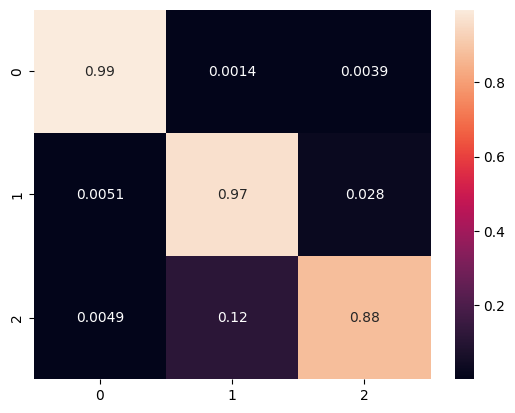

In [25]:
plot_confusion_matrix(model, shaped_test_data, shaped_test_target)

#### Metrics

In [26]:
def print_fold_metrics_summary(fold_metrics):
    # Convert fold_metrics (list of dicts) into a DataFrame
    metrics_df = pd.DataFrame(fold_metrics)
    
    # Calculate mean and standard error for each metric
    summary_df = pd.DataFrame({
        'Metric': ['accuracy', 'precision', 'recall', 'f1_score'],
        'Mean': [
            metrics_df['accuracy'].mean(),
            metrics_df['precision'].mean(),
            metrics_df['recall'].mean(),
            metrics_df['f1_score'].mean()
        ],
        'Standard Error': [
            metrics_df['accuracy'].std() / np.sqrt(len(metrics_df)),
            metrics_df['precision'].std() / np.sqrt(len(metrics_df)),
            metrics_df['recall'].std() / np.sqrt(len(metrics_df)),
            metrics_df['f1_score'].std() / np.sqrt(len(metrics_df))
        ]
    })

    # Print the summary table
    print(summary_df.to_string(index=False))


def print_overall_metrics(metrics):
    # Specify the desired order of metrics
    metric_order = ['accuracy', 'precision', 'recall', 'f1_score']
    # Create a DataFrame from the metrics dictionary
    metrics_df = pd.DataFrame.from_dict(metrics, orient='index', columns=['Value'])
    # Reindex the DataFrame to ensure the desired order
    metrics_df = metrics_df.reindex(metric_order)
    # Print the metrics table
    print(metrics_df.to_string(index=True, header=False))

In [27]:
print_fold_metrics_summary(fold_metrics)

   Metric     Mean  Standard Error
 accuracy 0.963170        0.000126
precision 0.963089        0.000227
   recall 0.963151        0.000234
 f1_score 0.963084        0.000224


In [28]:
print_overall_metrics(metrics)

accuracy   0.957216
precision  0.957102
recall     0.957215
f1_score   0.957128
